Data Cleansing

In [1]:
import numpy as np
import pandas as pd
import re
import time
import os
import inspect

from utils import save_dataset

dataset_original = pd.read_csv('./datasets/ChEMBL_original_dataset.csv', delimiter=';')

# Take out all values that have pChEMBL values
dataset_v1 = dataset_original[dataset_original['pChEMBL Value'].notna()]   # 1236, 45

# Check out the duplicates and take their mean values
dataset_v2 = dataset_v1.groupby('Molecule ChEMBL ID').mean()['Standard Value'].reset_index()

# calculate pChEMBL values
s_value = dataset_v2['Standard Value'].values
p_value = np.around(- np.log10(s_value/(10**(9))), 2)
dataset_v2['Calculated pChEMBL'] = p_value.tolist()


for i in range(0, dataset_v2.shape[0]):
    index = dataset_v2['Molecule ChEMBL ID'][i]
    smile = dataset_v1.loc[dataset_v1['Molecule ChEMBL ID'] == index]['Smiles'].drop_duplicates()
    dataframe = pd.DataFrame(smile)

    if i == 0:
        concat_df = dataframe
    else:
        concat_df = pd.concat([concat_df, dataframe], axis = 0)

concat_df = concat_df.reset_index()

all_structures = pd.concat([dataset_v2, concat_df], axis = 1)

save_dataset(all_structures)


Current path is: C:\Users\hewan\Downloads\ml-lsd1\datasets
Path already existed.
Dataset saved successfully.


Dataset Construction

In [2]:
import json
import numpy as np
import pandas as pd
import re
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs

from utils import save_dataset, get_parameters
from rdkit_utils import smiles_dataset

dataset = pd.read_csv('./datasets/all_structures.csv')


# change the parameters in .json file
dic = get_parameters(path = './settings/fp_settings.json', print_dict = False)

x = smiles_dataset(dataset_df = dataset, smiles_loc = 'Smiles',
                   fp_radius = dic.get("fp_radius"), fp_bits = dic.get("fp_bits"))

y = dataset['Calculated pChEMBL']

# change file_name to save as different datasets
save_dataset(x, file_name = dic.get("dataset_name"), idx = False)
save_dataset(y, file_name = dic.get("label_name"), idx = False)


json file path is: ./settings/fp_settings.json
Current path is: C:\Users\hewan\Downloads\ml-lsd1\datasets
Path already existed.
Dataset saved successfully.
Current path is: C:\Users\hewan\Downloads\ml-lsd1\datasets
Path already existed.
Dataset saved successfully.


Algorithm Hyperparamter Optimisation

In [3]:
import numpy as np
import pandas as pd
from utils import pipeline_optim

np.random.seed(42)
dataset = pd.read_csv('./datasets/3_512_x_main.csv')
target = pd.read_csv('./datasets/3_512_y_main.csv')

# generate optimization hyperparameters of algorithms

knn = pipeline_optim(dataset, target, random_seeds = 42, mode = 'knn')
ridge = pipeline_optim(dataset, target, random_seeds = 42, mode = 'ridge')
lasso = pipeline_optim(dataset, target, random_seeds = 42, mode = 'lasso')
elastic = pipeline_optim(dataset, target, random_seeds = 42, mode = 'elastic')
gb = pipeline_optim(dataset, target, random_seeds = 42, mode = 'gradientboosting')
rf = pipeline_optim(dataset, target, random_seeds = 42, mode = 'rf')
ada = pipeline_optim(dataset, target, random_seeds = 42, mode = 'adaboost')
extra = pipeline_optim(dataset, target, random_seeds = 42, mode = 'extratrees')
dt = pipeline_optim(dataset, target, random_seeds = 42, mode = 'dt')
svr = pipeline_optim(dataset, target, random_seeds = 42, mode = 'svr')

The best hyperparameters: KNeighborsRegressor(algorithm='kd_tree', leaf_size=40, n_neighbors=3, p=1,
                    weights='distance')
Time for optimization: 197.249816 seconds
*********************************
The best hyperparameters: Ridge()
Time for optimization: 0.421975 seconds
*********************************
The best hyperparameters: Lasso(alpha=0.01, max_iter=100000)
Time for optimization: 3.795652 seconds
*********************************
The best hyperparameters: ElasticNet(alpha=0.01, l1_ratio=0.2, max_iter=100000)
Time for optimization: 28.968697 seconds
*********************************
The best hyperparameters: GradientBoostingRegressor(criterion='squared_error', loss='huber',
                          min_samples_split=3)
Time for optimization: 2364.236002 seconds
*********************************
The best hyperparameters: RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=4)
Time for optimization: 318.321796 seconds
*******************

Model Fitting

In [4]:
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet

from utils import fit_result, get_parameters

np.random.seed(42)

dataset = pd.read_csv('./datasets/3_512_x_main.csv')
target = pd.read_csv('./datasets/3_512_y_main.csv')
x_values = dataset.values
y_values = target.values.ravel()


# import fitting_settings.json to retrive optimization hyperparameters for
# raidus = 3, fingerprint bits = 512 dataset
dic = get_parameters(path = './settings/fitting_settings.json', print_dict = False)

fit_result(x_values, y_values, KNeighborsRegressor(algorithm='ball_tree', leaf_size=20, n_neighbors=6, p=1, weights='distance'), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, Ridge(), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, Lasso(alpha=0.01, max_iter=100000), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, ElasticNet(alpha=0.01, l1_ratio=0.2, max_iter=100000), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, GradientBoostingRegressor(criterion='mse', loss='huber', min_samples_split=3), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=4), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, AdaBoostRegressor(learning_rate=1), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, ExtraTreesRegressor(), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, DecisionTreeRegressor(criterion='friedman_mse', min_samples_split=9), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, SVR(C=10), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))

json file path is: ./settings/fitting_settings.json
The average train score of all random states:0.998
The average test score of all random states:0.662
The average train rmse of all random states:0.051
The average test rmse of all random states:0.632
---------------------------------
The train score std: 0.0008
The test score std: 0.0473
The train rmse std: 0.0099
The test rmse std: 0.0522
---------------------------------
Time for fitting: 31.623404 seconds
*********************************
The average train score of all random states:0.923
The average test score of all random states:0.471
The average train rmse of all random states:0.306
The average test rmse of all random states:0.790
---------------------------------
The train score std: 0.0052
The test score std: 0.0689
The train rmse std: 0.0108
The test rmse std: 0.0592
---------------------------------
Time for fitting: 1.295144 seconds
*********************************
The average train score of all random states:0.688
The av

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\ensemble\_gb.py:475: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\an

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\ensemble\_gb.py:475: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\an

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

The average train score of all random states:0.833
The average test score of all random states:0.631
The average train rmse of all random states:0.450
The average test rmse of all random states:0.660
---------------------------------
The train score std: 0.0069
The test score std: 0.0408
The train rmse std: 0.0104
The test rmse std: 0.0404
---------------------------------
Time for fitting: 47.973367 seconds


C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\tree\_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
C:\Users\hewan\a

*********************************
The average train score of all random states:0.984
The average test score of all random states:0.695
The average train rmse of all random states:0.140
The average test rmse of all random states:0.600
---------------------------------
The train score std: 0.0010
The test score std: 0.0346
The train rmse std: 0.0043
The test rmse std: 0.0406
---------------------------------
Time for fitting: 16.405925 seconds
*********************************
The average train score of all random states:0.582
The average test score of all random states:0.500
The average train rmse of all random states:0.713
The average test rmse of all random states:0.769
---------------------------------
The train score std: 0.0167
The test score std: 0.0341
The train rmse std: 0.0151
The test rmse std: 0.0345
---------------------------------
Time for fitting: 32.854493 seconds
*********************************
The average train score of all random states:0.998
The average test score 

Plot Learning Curves

Current path is: C:\Users\hewan\Downloads\ml-lsd1\figures
Path created.


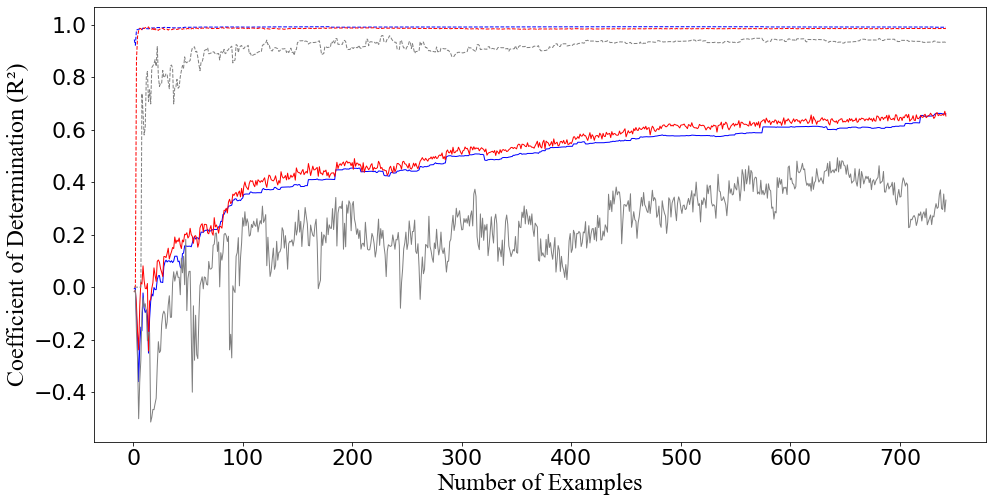

Figure saved successfully.


In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
import utils
from utils import plot_multi_learning_curves

np.random.seed(42)
dataset = pd.read_csv('./datasets/3_512_x_main.csv')
target = pd.read_csv('./datasets/3_512_y_main.csv')
x_values = dataset.values
y_values = target.values.ravel()

estimator1 = SVR(C=10)
estimator2 = RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=4)
estimator3 = DecisionTreeRegressor(criterion='friedman_mse', min_samples_split=9)

plot_multi_learning_curves(x_values, y_values, estimator1, estimator2, estimator3,
                           random_seed = 42, testsize = 0.2, mode = 'r2', autosave = 'y', interval = None)


tSNE

Current path is: C:\Users\hewan\Downloads\ml-lsd1\figures
Path already existed.


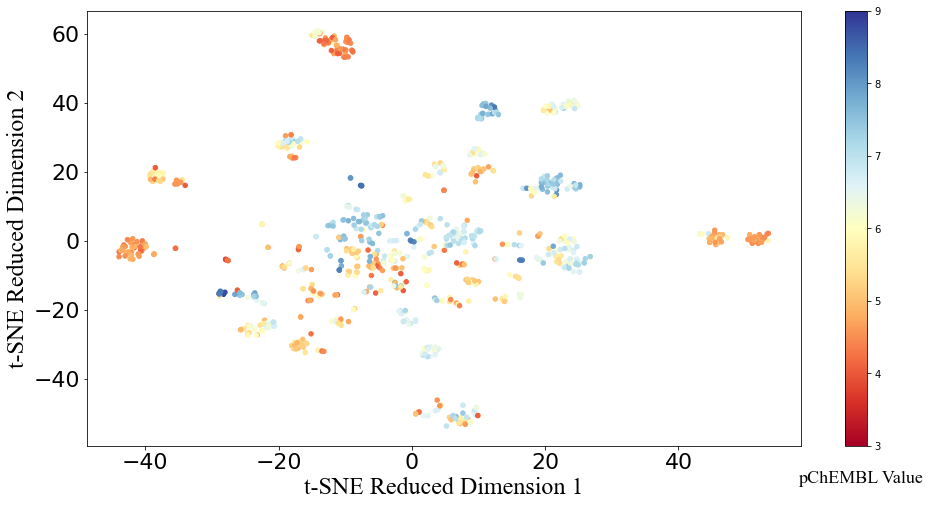

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.manifold import TSNE


np.random.seed(42)

path = os.path.join(os.getcwd(), 'figures')
print('Current path is:', path)

if os.path.exists(path) == True:
    pass
    print('Path already existed.')
else:
    os.mkdir(path)
    print('Path created.')

x_values = pd.read_csv('./datasets/3_512_x_main.csv').values
y_values = pd.read_csv('./datasets/3_512_y_main.csv').values.ravel()
tsne_descriptors = TSNE(n_components=2, random_state = 42)
x_tsne = tsne_descriptors.fit_transform(x_values)


# draw tsne
cm = plt.cm.get_cmap('RdYlBu')
plt.figure(figsize=(16, 8))
plt.xticks(size = 22)
plt.yticks(size = 22)
plt.xlabel('t-SNE Reduced Dimension 1',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('t-SNE Reduced Dimension 2',fontproperties = 'Times New Roman', size = 24)
plt.scatter(x_tsne[:, 0], x_tsne[:,1],c= y_values,vmin= 3, vmax= 9, s= 20, cmap=cm)
plt.colorbar()
plt.text(58, -70, "pChEMBL Value", fontproperties = 'Times New Roman', size = 18)
plt.savefig("figures/TSNE org.png", bbox_inches='tight', pad_inches= 0)

tsne_image = Image.open('figures/TSNE org.png')
tsne_image.show()


Neural Network

In [3]:
import torch
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from pytorch_lightning.metrics import functional
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random

from nn_utils import weight_reset, result_average_NN

dataset = pd.read_csv('./datasets/3_512_x_main.csv')
target = pd.read_csv('./datasets/3_512_y_main.csv')

class predict_model(nn.Module):
    def __init__(self, x_size, hidden1_size, hidden2_size, y_size):
        super(predict_model, self).__init__()
        self.hidden1 = nn.Linear(x_size, hidden1_size)
        self.batch1 = nn.BatchNorm1d(hidden1_size)
        self.hidden2 = nn.Linear(hidden1_size, hidden2_size)
        self.batch2 = nn.BatchNorm1d(hidden2_size)
        self.predict = nn.Linear(hidden2_size, y_size)
    def forward(self, input):
        result = self.hidden1(input)
        result = self.batch1(result)
        result = F.leaky_relu(result)
        result = self.hidden2(result)
        result = self.batch2(result)
        result = F.leaky_relu(result)
        result = self.predict(result)

Deployment 1 - Model Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import os
from sklearn.svm import SVR
import joblib

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit_utils import smiles_dataset
from utils import save_dataset, get_parameters

model_load = joblib.load('./models/model.pkl')
database = pd.read_csv('./screening_base/in-vitro_zinc/in-vitro.csv')

dic = get_parameters(path = './settings/fp_settings.json', print_dict = False)
database_fp = smiles_dataset(dataset_df = database, smiles_loc = 'smiles',
                   fp_radius = dic.get("fp_radius"), fp_bits = dic.get("fp_bits"))

save_dataset(database_fp, path = './datasets/screen_results/in-vitro_zinc/', file_name = 'in-vitro_bits', idx = False)


C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator SVR from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


json file path is: ./settings/fp_settings.json
Current path is: ./datasets/screen_results/in-vitro_zinc/
Path already existed.
Dataset saved successfully.


Deployment 2 - Virtual Screening

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import os
from sklearn.svm import SVR
import joblib

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit_utils import smiles_dataset
from utils import save_dataset


model_load = joblib.load('./models/model.pkl')
database = pd.read_csv('./screening_base/in-vitro_zinc/in-vitro.csv')
screen_database = pd.read_csv('./datasets/screen_results/in-vitro_zinc/in-vitro_bits.csv')

screen_result = model_load.predict(screen_database)
screen_result_fp = pd.DataFrame({'Predictive Results': screen_result})
database_result = pd.concat([database, screen_result_fp], axis = 1)

threshold_7 = database_result[database_result['Predictive Results'] > 7]

original_dataset = pd.read_csv('./datasets/all_structures.csv')
de_threshold_7 = threshold_7
for smile in original_dataset['Smiles']:
    for new_structure in threshold_7['smiles']:
        if smile == new_structure:
            index = threshold_7[threshold_7['smiles'] == smile].index[0]
            print('overlap found at position: {:01d}'.format(index))
            de_threshold_7 = de_threshold_7.drop(index = index, axis = 0)
        else:
            pass

save_dataset(threshold_7, path = './datasets/screen_results/in-vitro_zinc/', file_name = 'threshold_7', idx = False)
save_dataset(de_threshold_7, path = './datasets/screen_results/in-vitro_zinc/', file_name = 'de_threshold_7', idx = False)


C:\Users\hewan\anaconda3\envs\ml-lsd1\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


overlap found at position: 253636
overlap found at position: 297437
overlap found at position: 32529
overlap found at position: 64469
overlap found at position: 92462
overlap found at position: 291060
Current path is: ./datasets/screen_results/in-vitro_zinc/
Path already existed.
Dataset saved successfully.
Current path is: ./datasets/screen_results/in-vitro_zinc/
Path already existed.
Dataset saved successfully.
